In [ ]:
# ========================================
# IMPORTS
# ========================================
"""
Importación de librerías necesarias para procesamiento de lenguaje natural, 
visualización, entrenamiento de modelos de clasificación clásicos y embeddings contextuales.
Incluye compatibilidad con spaCy, BERT (BETO), NLPaug, y LLaMA vía Ollama.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Librerías Generales
import re
import random
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import os
import joblib

# Librerías de Manejo de Datos y Visualización
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Librerías de Procesamiento de Lenguaje Natural
import nltk
import emoji
import spacy
from wordsegment import load, segment
import nlpaug.augmenter.word as naw

# Librerías de Machine Learning
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import issparse

# Ollama
from ollama import Client

c:\Users\gusta\OneDrive\Documentos\Codes\OctavoSemestre\RetoTeset\reto\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# ========================================
# CONFIGURACION Y CARGA DE DATOS
# ========================================
"""
Carga del dataset, configuración de semilla aleatoria y preparación inicial del entorno NLP.
Incluye inicialización de etiquetado binario (LabelEncoder) y carga de modelos spaCy y WordSegment.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

random_state = 1
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('omw-1.4')
nlp = spacy.load("es_core_news_sm")
load()

df = pd.read_csv("data.csv")
label_encoder = LabelEncoder()
label_encoder.classes_ = np.array(['control', 'anorexia']) 
df['label_enc'] = label_encoder.transform(df['class'])
df.info()
df.describe()
df.head(5)


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\gusta\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     1500 non-null   object
 1   tweet_id    1500 non-null   object
 2   tweet_text  1500 non-null   object
 3   class       1500 non-null   object
 4   label_enc   1500 non-null   int32 
dtypes: int32(1), object(4)
memory usage: 52.9+ KB


,user_id,tweet_id,tweet_text,class,label_enc
0,user0001,0d3ed29586ce,Cheesecake saludable sin azúcar y sin lactosa ...,control,0
1,user0002,c3cf897a495b,ser como ellas ♡♡\n #HastaLosHuesos,anorexia,1
2,user0003,5041d85c45c6,"Comida Real o , la clave para estar más sana, ...",control,0
3,user0004,d18285d3c7ec,Entre el cambio de hora y la bajada de las #te...,control,0
4,user0005,4d81892f3217,Hace mucho tiempo no sentía mi cuerpo tan frío,anorexia,1


In [ ]:
# ========================================
# PREPROCESAMIENTO BETO
# ========================================
"""
Transformación de textos usando embeddings contextuales de BETO (BERT entrenado en español).
Se aplican: demojización, tokenización, extracción del vector CLS y reducción dimensional con SVD.

Autor(es):
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

def convert_emojis(text):
    return emoji.demojize(text)

def preprocess_text_bert(text):
    text = convert_emojis(text)
    encoded_input = tokenizer(text, padding=True, truncation=True, max_length=256, return_tensors='tf')
    model_output = model(encoded_input)
    embeddings = model_output.last_hidden_state[:, 0, :].numpy()
    return embeddings.flatten()

print("Procesando embeddings BETO...")
df['tweet_text_beto'] = df['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix = np.stack(df['tweet_text_beto'].values)
embeddings_scaled = StandardScaler().fit_transform(embeddings_matrix)
svd = TruncatedSVD(n_components=500, random_state=random_state)
X_beto = svd.fit_transform(embeddings_scaled)


Some layers from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Procesando embeddings BETO...


In [ ]:
# ========================================
# PREPROCESAMIENTO NoBETO (BoW)
# ========================================
"""
Pipeline clásico de procesamiento de texto: limpieza, lematización, segmentación de hashtags,
y extracción de características con Bag of Words (CountVectorizer con n-gramas).
Incluye cálculo de una métrica adicional: ratio de palabras en mayúsculas.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""


def split_hashtag(tag):
    '''
    Divide un hashtag en palabras separadas utilizando varias técnicas de segmentación.
    Esta función procesa hashtags y los convierte en frases legibles utilizando 
    dos métodos principales: detección de CamelCase y segmentación de palabras.
    - Primero elimina el símbolo '#' si existe
    - Intenta dividir por patrones CamelCase (mayúscula después de minúscula)
    - Si no hay patrones CamelCase, utiliza la biblioteca wordsegment para 
      identificar palabras dentro del texto concatenado
    - En caso de error durante la segmentación, devuelve el hashtag original en minúsculas
    '''
    tag = tag.lstrip('#')
    camel_split = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', tag).lower()
    if camel_split == tag.lower():
        try:
            segmented = segment(tag.lower())
            return " ".join(segmented) if segmented else tag.lower()
        except:
            return tag.lower()
    return camel_split


def preprocess_text_no_bert(text):
    '''
    Esta función realiza múltiples operaciones de limpieza y normalización en un texto
    para prepararlo para análisis de lenguaje natural. El procesamiento incluye:
    conversión de emojis a texto, segmentación de hashtags, eliminación de URLs, 
    menciones, números, palabras vacías, y lematización de palabras.

    - Convierte emojis a texto descriptivo usando la función 'convert_emojis'
    - Divide hashtags en palabras separadas usando 'split_hashtag'
    - Elimina URLs, menciones (@usuario), y números
    - Elimina palabras vacías (stop words) y signos de puntuación
    - Lematiza las palabras restantes
    - Utiliza el pipeline de spaCy (objeto 'nlp') para procesamiento de lenguaje
    '''
    text = convert_emojis(text).lower()
    hashtags = re.findall(r"#\w+", text) # Encuentra hashtags
    for tag in hashtags:
        text = text.replace(tag, split_hashtag(tag))
    text = re.sub(r"http\S+|www\S+|https\S+", "", text) # Elimina URLs
    text = re.sub(r"@\w+", "", text) # Elimina menciones
    text = re.sub(r"\d+", "", text) # Elimina números
    doc = nlp(text)
    # Versión lematizada de las palabras que no son stop words ni puntuación ni números
    lemmatized_words = [
        token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.like_num]
    cleaned = " ".join(lemmatized_words)
    return cleaned


def calculate_uppercase_ratio(text):
    '''
    Calcula la proporción de palabras en mayúsculas en un texto dado.
    - Divide el texto en palabras usando el método split()
    - Filtra las palabras que están completamente en mayúsculas
    - Devuelve la proporción de palabras en mayúsculas respecto al total de palabras
    - Si no hay palabras, devuelve 0.0
    '''
    words = text.split()
    if not words:
        return 0.0
    uppercase_words = [w for w in words if w.isupper()]
    return len(uppercase_words) / len(words)


print("Procesando pipeline BoW...")
df['uppercase_ratio'] = df['tweet_text'].apply(calculate_uppercase_ratio)
features = df['tweet_text'].apply(preprocess_text_no_bert)
df['cleaned_tweet'] = features

# Bag of Words con CountVectorizer, incluyendo unigramas y bigramas.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_bow = vectorizer.fit_transform(df['cleaned_tweet'])

y = df['label_enc'].values

Procesando pipeline BoW...


In [ ]:
# ========================================
# LLAMA VIA OLLAMA (Clasificación Generativa)
# ========================================
"""
Clasificador generativo usando LLaMA a través de la API local de Ollama.
Se genera un prompt en español para evaluar la presencia de conductas asociadas a anorexia en cada tweet.
Predicciones son paralelizadas con ThreadPoolExecutor y se guardan/reutilizan desde archivo CSV.

Autor(es):
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

ollama_client = Client(host='http://localhost:11434')

def llama_classify_tweet_generate(text):
    '''
    Genera un prompt para clasificar un tweet en español usando LLaMA a través de Ollama.
    - El prompt solicita al modelo que analice el tweet y determine si sugiere conductas asociadas a anorexia.
    - El modelo responde con 1 si detecta evidencia de tal conducta, o 0 si no hay indicios suficientes.
    - La función devuelve 1 o 0 basado en la respuesta del modelo.
    - Se utiliza un cliente de Ollama para interactuar con el modelo LLaMA.
    '''
    prompt = (
        "A continuación se presenta un tweet escrito en español. Tu tarea es analizarlo cuidadosamente y "
        "determinar si su contenido refleja señales de conductas asociadas a trastornos alimenticios, específicamente anorexia. "
        "Considera el tono emocional, la mención de hábitos alimenticios, el lenguaje corporal implícito o explícito, "
        "y cualquier indicio de preocupación extrema por el peso o la comida.\n"
        f"Tweet: '{text}'\n"
        "¿Este tweet sugiere conductas relacionadas con anorexia?: "
        "Responde únicamente con 1 si detectas evidencia que sugiere tal conducta, o con 0 si no hay indicios suficientes."
    )
    response = ollama_client.generate(model='llama3', prompt=prompt)
    reply = response['response'].strip()
    return 1 if '1' in reply else 0

def classify_all_tweets_parallel(texts, max_workers=4):
    '''
    Clasifica todos los tweets en paralelo utilizando LLaMA a través de Ollama.
    - Utiliza ThreadPoolExecutor para ejecutar la función de clasificación en múltiples hilos.
    - La función llama a "llama_classify_tweet_generate" para cada tweet en la lista de textos.
    - Devuelve una lista de resultados con las predicciones (1 o 0) para cada tweet.
    '''
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        results = list(tqdm(executor.map(llama_classify_tweet_generate, texts), total=len(texts)))
    return results

# Verificar si ya existe un archivo de predicciones
if os.path.exists("llama_predictions.csv"):
    print("Archivo de predicciones encontrado. Cargando desde disco...")
    df_pred = pd.read_csv("llama_predictions.csv")
    df['llama_pred'] = df_pred['llama_pred']
else:
    print("Clasificando en paralelo con LLaMA...")
    df['llama_pred'] = classify_all_tweets_parallel(df['tweet_text'].tolist(), max_workers=6)
    
    # Guardar predicciones
    df[['tweet_id', 'llama_pred']].to_csv("llama_predictions.csv", index=False)
    print("Predicciones guardadas.")

#Estimated 20min to 50min duration

Archivo de predicciones encontrado. Cargando desde disco...


In [ ]:
# ========================================
# AUGMENTADOR 
# ========================================
"""
Aplicación de técnicas de aumentación textual para la rama BoW.
Se pueden aplicar sustituciones contextuales con BERT o técnicas clásicas como sinónimos (WordNet) e intercambio de palabras.
El usuario puede activar aumentación con AUGMENT_DATA = True y guardar el nuevo dataset extendido.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

AUGMENT_DATA = False
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)

def generate_augmented_bow_data(X_texts, y_labels, augment_factor=1):
    aug_texts, aug_labels = [], []
    for i, text in enumerate(X_texts):
        for _ in range(augment_factor):
            try:
                aug = augmenter.augment(text)
            except:
                aug = text
            aug_texts.append(aug)
            aug_labels.append(y_labels[i])
    return aug_texts, aug_labels

# Augmenters configurados (usa español cuando es posible)
syn_aug = naw.SynonymAug(aug_src='wordnet', lang='spa', aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

def augment_text_complex(text, num_augments=1):
    augmented_texts = []
    for _ in range(num_augments):
        aug_type = random.choice(['synonym', 'swap'])
        if aug_type == 'synonym':
            augmented = syn_aug.augment(text)
        elif aug_type == 'swap':
            augmented = swap_aug.augment(text)
        else:
            augmented = text
        if isinstance(augmented, list):
            augmented = augmented[0]
        augmented_texts.append(augmented)
    return augmented_texts

original_texts = list(df['cleaned_tweet'])
original_labels = list(y)

# Si se elige aumentar los datos, se generan versiones aumentadas de los textos originales
if AUGMENT_DATA:
    print("Generando datos aumentados para BoW...")
    augmented_texts = []
    augmented_labels = []

    for text, label in zip(original_texts, original_labels):
        augmented_versions = augment_text_complex(text, num_augments=2)
        augmented_texts.extend(augmented_versions)
        augmented_labels.extend([label] * len(augmented_versions))


    # Dataset extendido: original + aumentados
    combined_texts = list(df['cleaned_tweet']) + augmented_texts
    combined_labels = list(y) + augmented_labels

    # Guardar dataset
    df_aug = pd.DataFrame({
        'tweet_text': combined_texts,
        'label_enc': combined_labels
    })
    df_aug.to_csv("augmented_data.csv", index=False)
    print("Datos aumentados guardados como 'augmented_data.csv'.")

else:
    print("AUGMENT_DATA = False — Usando solo los datos originales.")
    combined_texts = original_texts
    combined_labels = original_labels

vectorizer = CountVectorizer(max_features=1000, ngram_range=(1, 2))
X_aug_bow = vectorizer.fit_transform(combined_texts)
y_aug_bow = np.array(combined_labels)

AUGMENT_DATA = False — Usando solo los datos originales.


In [ ]:
# ========================================
# FUNCIONES DE EVALUACION CON CV
# ========================================
"""
Define funciones auxiliares para evaluar modelos con validación cruzada:
- Matriz de confusión
- Curva ROC
- Curva de aprendizaje
También guarda los mejores modelos y registra métricas en un diccionario global `results_list`.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

results_list = []

def plot_confusion_matrix_cv(y_true, y_pred, labels, model_name, pipeline_name, ax):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicción")
    ax.set_ylabel("Real")

def plot_roc_curve_cv(model, X, y, cv, ax):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    for i, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        model.fit(X[train_idx], y[train_idx])
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X[test_idx])[:,1]
        else:
            y_score = model.decision_function(X[test_idx])
        y_test_bin = label_binarize(y[test_idx], classes=np.unique(y)).ravel()
        fpr, tpr, _ = roc_curve(y_test_bin, y_score)
        auc = roc_auc_score(y_test_bin, y_score)
        ax.plot(fpr, tpr, label=f"Fold {i+1} (AUC={auc:.2f})")
    ax.plot([0, 1], [0, 1], '--', color='gray')
    ax.set_title("ROC Curve")
    ax.set_xlabel("Falsos Positivos")
    ax.set_ylabel("Verdaderos Positivos")
    ax.grid(True)
    ax.legend(fontsize='small')

def plot_learning_curve_cv(model, X, y, cv, ax):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 5),
        cv=cv, scoring='f1_weighted', n_jobs=-1
    )
    train_mean, train_std = np.mean(train_scores, axis=1), np.std(train_scores, axis=1)
    val_mean, val_std = np.mean(val_scores, axis=1), np.std(val_scores, axis=1)

    ax.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    ax.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='orange')
    ax.plot(train_sizes, train_mean, 'o--', color='blue', label='Train Mean')
    ax.plot(train_sizes, val_mean, 'o-', color='orange', label='Val Mean')

    ax.set_title("Learning Curve")
    ax.set_xlabel("Muestras de entrenamiento")
    ax.set_ylabel("F1 Score")
    ax.grid(True)
    ax.legend(fontsize='small')

def evaluate_model_cv(model, param_grid, X, y, model_name, pipeline_name, cv=5, save_dir="saved_models"):
    """
    Realiza búsqueda de hiperparámetros con GridSearchCV y evaluación con CV:
    - Ajusta modelo y predice con cross_val_predict.
    - Guarda el mejor modelo a disco.
    - Muestra métricas, matriz de confusión, ROC y curva de aprendizaje.
    - Almacena resultados en `results_list`.
    """
    print(f"\nEvaluando {model_name} en {pipeline_name} con KFold CV...")

    os.makedirs(save_dir, exist_ok=True)

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=random_state)
    grid = GridSearchCV(model, param_grid, cv=skf, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X, y)
    best_model = grid.best_estimator_
    
    # Guardar modelo
    model_filename = f"{save_dir}/{pipeline_name}_{model_name.replace(' ', '_')}.joblib"
    joblib.dump(best_model, model_filename)
    print(f"Modelo guardado como {model_filename}")
    
    y_pred = cross_val_predict(best_model, X, y, cv=skf, n_jobs=-1)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted')
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Subplots: 1 row x 3 cols
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f"{model_name} - {pipeline_name}", fontsize=14)

    plot_confusion_matrix_cv(y, y_pred, labels=np.unique(y), model_name=model_name, pipeline_name=pipeline_name, ax=axs[0])
    if len(np.unique(y)) == 2:
        plot_roc_curve_cv(best_model, X, y, cv, ax=axs[1])
    else:
        axs[1].axis('off')  # ROC not applicable
    plot_learning_curve_cv(best_model, X, y, cv, ax=axs[2])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Leave space for suptitle
    plt.show()

    results_list.append({
        'Pipeline': pipeline_name,
        'Model': model_name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'Best Params': grid.best_params_
    })
    


In [ ]:
# ========================================
# PARÁMETROS DE GRIDSEARCH
# ========================================
"""
Define los espacios de búsqueda de hiperparámetros para los clasificadores:
- Logistic Regression
- Random Forest
- Support Vector Machines

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1, 5],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200, 500]
}
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'max_features': ['sqrt']
}
param_grid_svm = [
    {
        'C': [0.1, 1, 10],
        'kernel': ['linear'],
        'shrinking': [True]
    },
    {
        'C': [0.1, 1, 10],
        'kernel': ['rbf'],
        'gamma': ['scale'],
        'shrinking': [True]
    }
]


=== Evaluando modelos en pipeline: BETO ===

Evaluando Logistic Regression en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Logistic_Regression.joblib


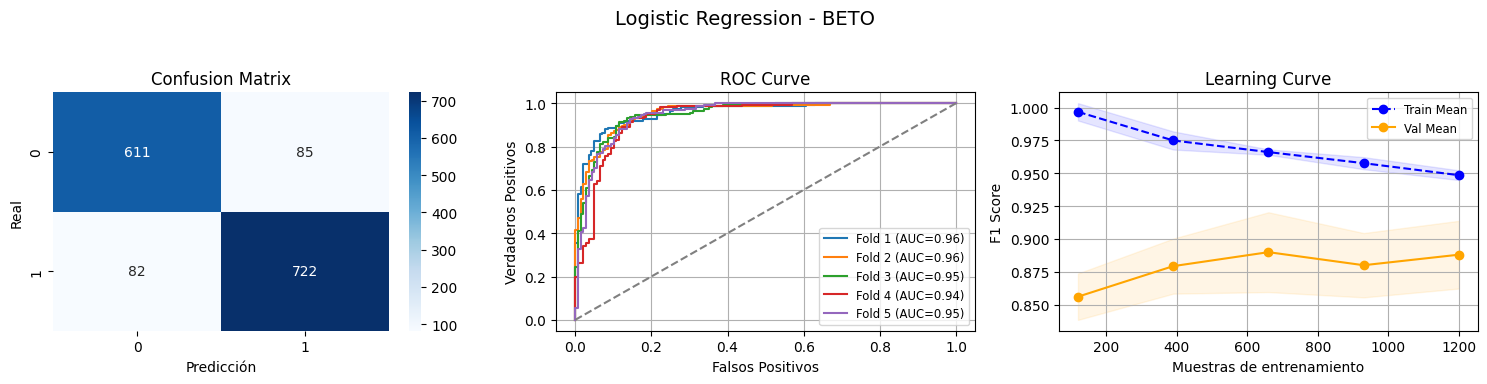


Evaluando Random Forest en BETO con KFold CV...
Modelo guardado como saved_models/BETO_Random_Forest.joblib


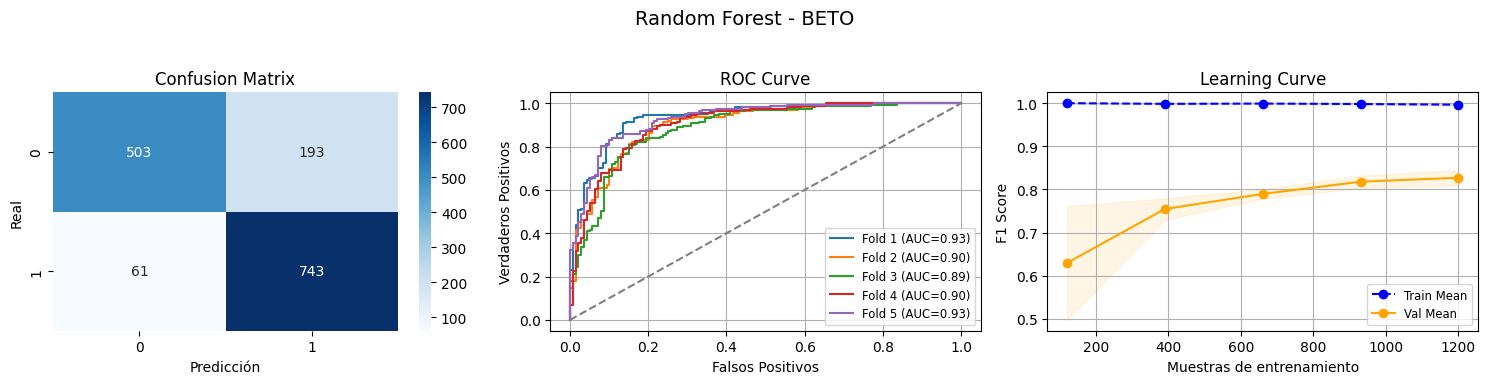


Evaluando SVM en BETO con KFold CV...
Modelo guardado como saved_models/BETO_SVM.joblib


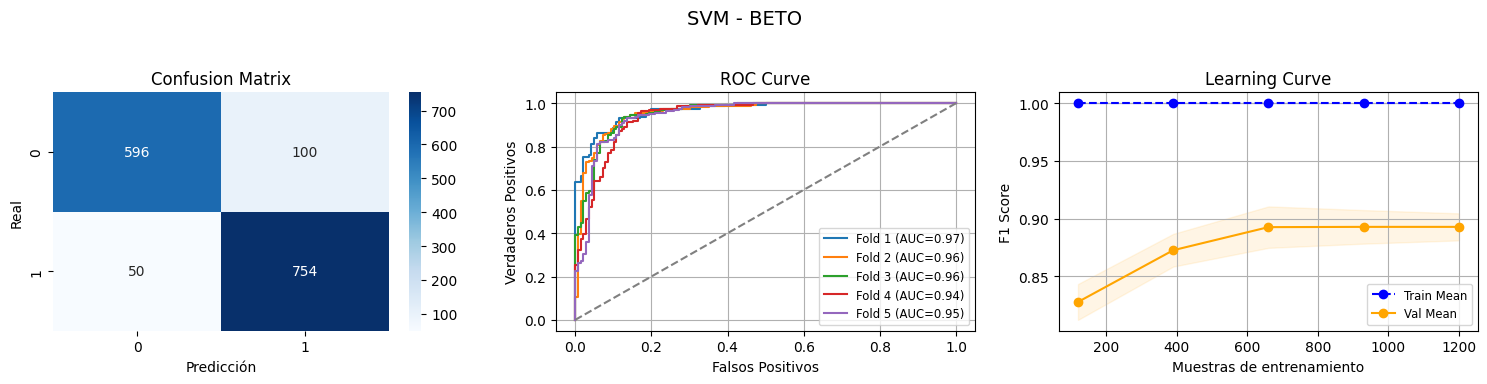

In [ ]:
# ========================================
# EVALUACIÓN DEL MODELO BETO
# ========================================
"""
Evalúa múltiples clasificadores clásicos sobre los embeddings generados por BETO:
- Logistic Regression
- Random Forest
- SVM
Se aplican validación cruzada, búsqueda de hiperparámetros, y visualización de resultados.

Autor(es):
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
"""

print("\n=== Evaluando modelos en pipeline: BETO ===")
X_beto_input = X_beto if not issparse(X_beto) else X_beto.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_beto_input, y, name, "BETO")



=== Evaluando modelos en pipeline: BoW ===

Evaluando Logistic Regression en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Logistic_Regression.joblib


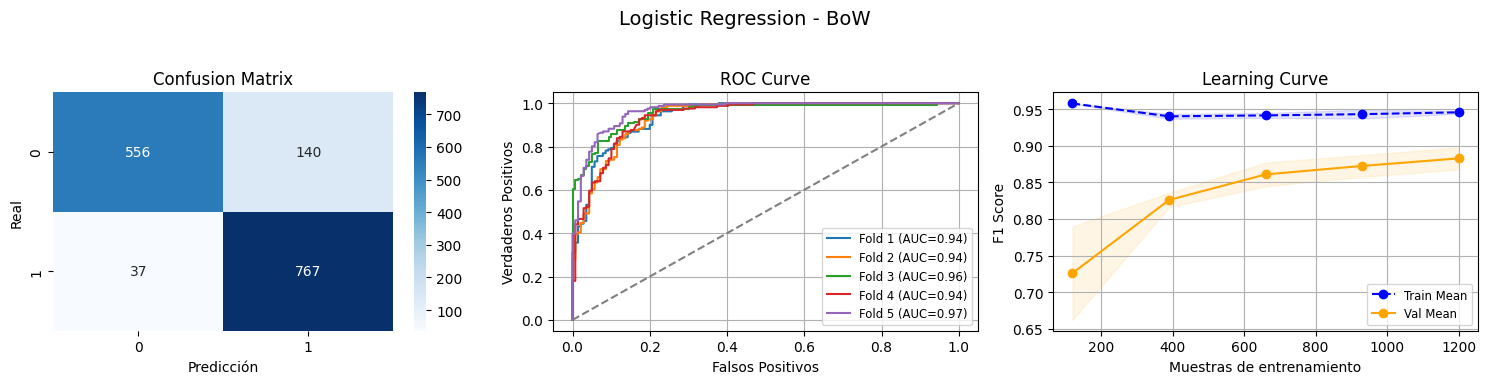


Evaluando Random Forest en BoW con KFold CV...
Modelo guardado como saved_models/BoW_Random_Forest.joblib


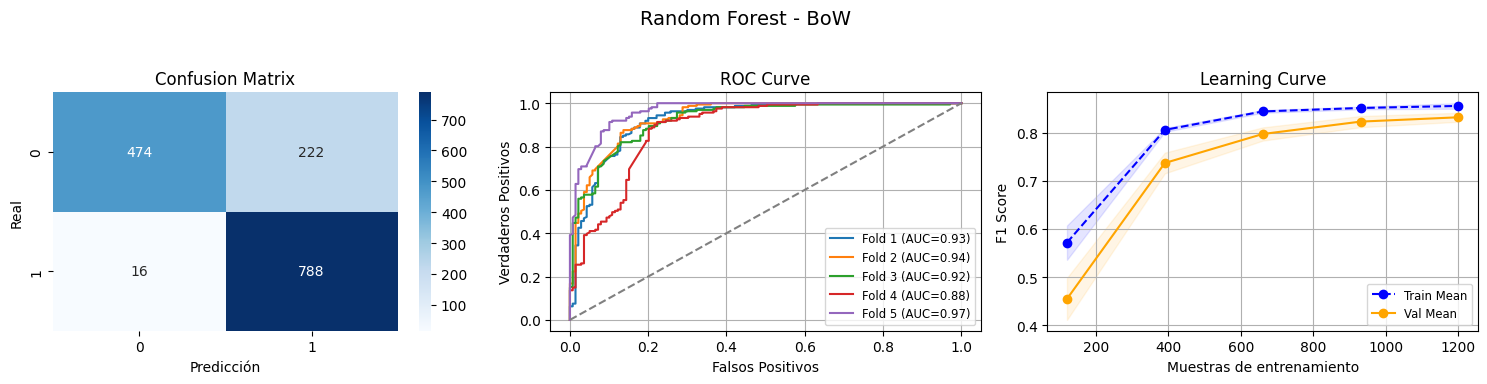


Evaluando SVM en BoW con KFold CV...
Modelo guardado como saved_models/BoW_SVM.joblib


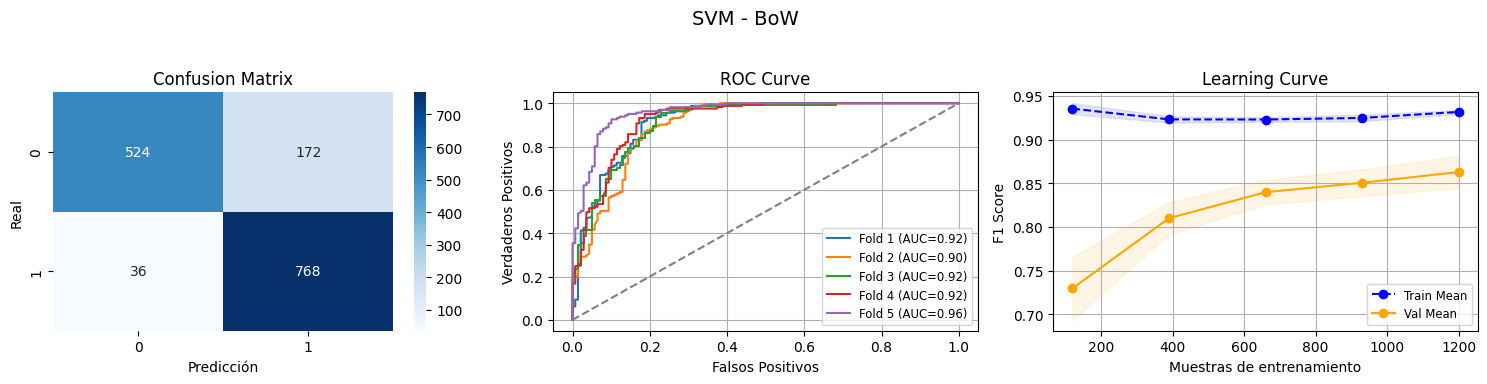

In [ ]:
# ========================================
# EVALUACIÓN DEL MODELO BoW
# ========================================
"""
Evalúa clasificadores clásicos sobre las representaciones Bag-of-Words (originales o aumentadas).
Incluye exactamente el mismo conjunto de modelos y proceso que BETO.
Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

print("\n=== Evaluando modelos en pipeline: BoW ===")
X_bow_input = X_aug_bow if not issparse(X_aug_bow) else X_aug_bow.tocsr()
for clf, name, param_grid in [
    (LogisticRegression(random_state=random_state), "Logistic Regression", param_grid_lr),
    (RandomForestClassifier(random_state=random_state), "Random Forest", param_grid_rf),
    (SVC(probability=True, random_state=random_state), "SVM", param_grid_svm)
]:
    evaluate_model_cv(clf, param_grid, X_bow_input, y_aug_bow, name, "BoW")


Evaluando LLaMA con clasificación generativa...


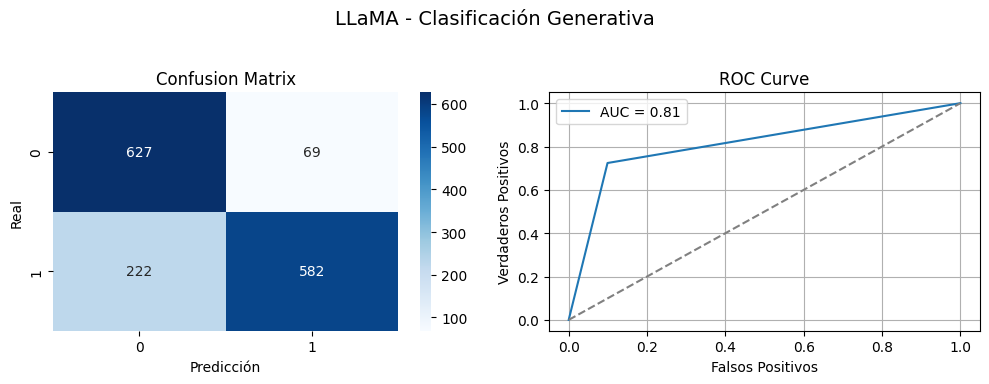

In [ ]:
# ========================================
# EVALUACIÓN DEL MODELO LLaMA
# ========================================
"""
Evalúa el desempeño del modelo generativo LLaMA, comparando predicciones guardadas contra etiquetas reales.
Se reportan métricas clásicas (Accuracy, F1, Precision, Recall) y se grafican:
- Matriz de confusión
- Curva ROC

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
"""

print("\nEvaluando LLaMA con clasificación generativa...")

# Asegurar consistencia de etiquetas (1 = conducta asociada a anorexia)
if label_encoder.classes_[0] == 'T':  # T se codificó como 0, invertir
    y_true_llama = 1 - df['label_enc'].values
else:
    y_true_llama = df['label_enc'].values

y_llama_pred = df['llama_pred'].values

# Métricas
acc = accuracy_score(y_true_llama, y_llama_pred)
prec = precision_score(y_true_llama, y_llama_pred, average='weighted')
rec = recall_score(y_true_llama, y_llama_pred, average='weighted')
f1 = f1_score(y_true_llama, y_llama_pred, average='weighted')

# Gráficas
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle("LLaMA - Clasificación Generativa", fontsize=14)

# Confusion Matrix
plot_confusion_matrix_cv(
    y_true_llama,
    y_llama_pred,
    labels=[0, 1],
    model_name="LLaMA",
    pipeline_name="Generativo",
    ax=axs[0]
)

# ROC Curve
if len(np.unique(y_true_llama)) == 2:
    y_true_bin = label_binarize(y_true_llama, classes=[0, 1]).ravel()
    fpr, tpr, _ = roc_curve(y_true_bin, y_llama_pred)
    auc = roc_auc_score(y_true_bin, y_llama_pred)

    axs[1].plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    axs[1].plot([0, 1], [0, 1], '--', color='gray')
    axs[1].set_title("ROC Curve")
    axs[1].set_xlabel("Falsos Positivos")
    axs[1].set_ylabel("Verdaderos Positivos")
    axs[1].grid(True)
    axs[1].legend()
else:
    axs[1].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Registrar resultados
results_list.append({
    'Pipeline': 'LLaMA',
    'Model': 'Generativo',
    'Accuracy': acc,
    'Precision': prec,
    'Recall': rec,
    'F1-Score': f1,
    'Best Params': 'N/A'
})

In [ ]:
# ========================================
# RESUMEN DE RESULTADOS
# ========================================
"""
Compila y muestra un resumen de métricas para cada pipeline/modelo evaluado,
ordenando por F1-Score para facilitar comparación de rendimiento.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_results = pd.DataFrame(results_list)
print("\nResumen de resultados:") 
print(df_results.sort_values(by='F1-Score', ascending=False).to_string(index=False))



Resumen de resultados:
Pipeline               Model  Accuracy  Precision   Recall  F1-Score                                                                                                    Best Params
    BETO                 SVM  0.900000   0.901323 0.900000  0.899645                                                {'C': 10, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
    BETO Logistic Regression  0.888667   0.888641 0.888667  0.888650                                           {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
     BoW Logistic Regression  0.882000   0.888315 0.882000  0.880837                                            {'C': 0.5, 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
     BoW                 SVM  0.861333   0.872095 0.861333  0.859233                                                 {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'shrinking': True}
     BoW       Random Forest  0.841333   0.867035 0.841333  0.836563  {'max_

In [ ]:
# =========================================
# EVALUACIÓN CON TEST SET | CARGA DE DATOS
# =========================================
"""
Carga y codificación de etiquetas del conjunto de prueba (`test.csv`).
Se asegura la misma codificación binaria usada en el conjunto de entrenamiento.
Autor(es):
    - Gustavo Téllez Mireles A01747114
"""
df_test = pd.read_csv("test.csv")
label_encoder_test = LabelEncoder()
label_encoder_test.classes_ = np.array(['control', 'anorexia']) 
df_test['label_enc'] = label_encoder_test.transform(df_test['class'])
y_test = df_test['label_enc'].values
df_test.head(5)

,user_id,tweet_id,tweet_text,class,label_enc
0,user1501,a2ffa2b1425c,A ver cuando se empiezan con las de anorexia y...,anorexia,1
1,user1503,bfdce07b546c,"¡7 días, 7 razones para entrenar!\n-\nLlegamos...",control,0
2,user1506,fdcb32f44ce7,Como bajar peso comiendo sin parar.\n #Tips,anorexia,1
3,user1508,17203fc43352,"No importa si ese platillo luce bien,delicioso...",anorexia,1
4,user1509,3947b6578c8e,Por supuesto el polo es de fruta y casero\n\nM...,control,0


In [ ]:
# =========================================
# EVALUACIÓN CON TEST SET | PREPROCESAMIENTO
# =========================================
"""
Preprocesamiento del conjunto de prueba para ambas ramas:
- BoW: limpieza, lematización y vectorización usando el vectorizador original.
- BETO: demojización, tokenización y embeddings, seguidos de SVD.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

# Preprocesamiento BoW
print("Procesando BoW para el conjunto de prueba...")
df_test['cleaned_tweet'] = df_test['tweet_text'].apply(preprocess_text_no_bert)
X_bow_test = vectorizer.transform(df_test['cleaned_tweet'])

# Preprocesamiento BETO
print("Procesando embeddings BETO para el conjunto de prueba...")
df_test['tweet_text_beto'] = df_test['tweet_text'].apply(preprocess_text_bert)
embeddings_matrix_test = np.stack(df_test['tweet_text_beto'].values)
embeddings_scaled_test = StandardScaler().fit_transform(embeddings_matrix_test)
X_beto_test = svd.transform(embeddings_scaled_test)


Procesando BoW para el conjunto de prueba...
Procesando embeddings BETO para el conjunto de prueba...


In [ ]:
# =========================================
# EVALUACIÓN CON TEST SET | Out-of-Vocabulary (OOV) CHECK
# =========================================
"""
Verifica la cantidad de palabras del conjunto de prueba que no estaban en el vocabulario de entrenamiento.
Esto es útil para estimar posibles pérdidas de información en modelos BoW.

Autor(es):
    - Gustavo Téllez Mireles A01747114
"""

df_test.head(5)
from collections import Counter
train_vocab = set(" ".join(df['cleaned_tweet']).split())
test_vocab = set(" ".join(df_test['cleaned_tweet']).split())
oov_words = test_vocab - train_vocab
print(f"Out-of-vocabulary words in test set: {len(oov_words)} / {len(test_vocab)}")


Out-of-vocabulary words in test set: 496 / 1536


In [ ]:
# =========================================
# EVALUACION TEST SET | CLASIFICADORES CLASICOS
# =========================================
"""
Carga los modelos entrenados (LogReg, RF, SVM para BoW y BETO), predice sobre `test.csv`
y muestra métricas de desempeño: Accuracy, Precision, Recall, F1-Score.

Autor(es):
    - Aldehil de Jesús Sánchez Hernández A01748442
    - Gustavo Téllez Mireles A01747114
    - Jorge Iván Rodríguez Reyes A01747131
    - Eduardo Francisco Lugo Quintana A01747490
"""

saved_models_dir = "saved_models"
model_files = [f for f in os.listdir(saved_models_dir) if f.endswith(".joblib")]

print("\n=== Evaluando modelos en conjunto de prueba ===")
for model_file in model_files:
    model_path = os.path.join(saved_models_dir, model_file)
    model = joblib.load(model_path)
    pipeline_name, model_name = model_file.replace(".joblib", "").split("_", 1)

    if pipeline_name == "BETO":
        X_test = X_beto_test
    elif pipeline_name == "BoW":
        X_test = X_bow_test
    else:
        continue

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"\nModelo: {model_name} - Pipeline: {pipeline_name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")


# =========================================
# EVALUACION TEST SET | LLaMA
# =========================================
"""
Evalúa el modelo generativo LLaMA en el conjunto de prueba:
- Clasifica cada tweet usando el prompt definido.
- Guarda resultados para evitar recálculo.
- Reporta métricas como los modelos clásicos.
"""
# Evaluar LLaMA en conjunto de prueba
print("\nEvaluando LLaMA en conjunto de prueba...")
if os.path.exists("llama_test_predictions.csv"):
    print("Predicciones de test encontradas. Cargando desde disco...")
    y_llama_test_pred = pd.read_csv("llama_test_predictions.csv")['llama_test_pred'].values
else:
    print("\nEvaluando LLaMA en conjunto de prueba...")
    y_llama_test_pred = df_test['tweet_text'].apply(llama_classify_tweet_generate).values
    pd.DataFrame({'llama_test_pred': y_llama_test_pred}).to_csv("llama_test_predictions.csv", index=False)
    print("Predicciones de test guardadas.")

acc_llama = accuracy_score(y_test, y_llama_test_pred)
prec_llama = precision_score(y_test, y_llama_test_pred, average='weighted')
rec_llama = recall_score(y_test, y_llama_test_pred, average='weighted')
f1_llama = f1_score(y_test, y_llama_test_pred, average='weighted')

print("\nModelo: LLaMA - Pipeline: Generativo")
print(f"Accuracy: {acc_llama:.4f}")
print(f"Precision: {prec_llama:.4f}")
print(f"Recall: {rec_llama:.4f}")
print(f"F1-Score: {f1_llama:.4f}")


=== Evaluando modelos en conjunto de prueba ===

Modelo: Logistic_Regression - Pipeline: BETO
Accuracy: 0.8680
Precision: 0.8684
Recall: 0.8680
F1-Score: 0.8681

Modelo: Random_Forest - Pipeline: BETO
Accuracy: 0.8640
Precision: 0.8689
Recall: 0.8640
F1-Score: 0.8628

Modelo: SVM - Pipeline: BETO
Accuracy: 0.8920
Precision: 0.8921
Recall: 0.8920
F1-Score: 0.8920

Modelo: Logistic_Regression - Pipeline: BoW
Accuracy: 0.8520
Precision: 0.8589
Recall: 0.8520
F1-Score: 0.8503

Modelo: Random_Forest - Pipeline: BoW
Accuracy: 0.8320
Precision: 0.8561
Recall: 0.8320
F1-Score: 0.8270

Modelo: SVM - Pipeline: BoW
Accuracy: 0.8400
Precision: 0.8559
Recall: 0.8400
F1-Score: 0.8366

Evaluando LLaMA en conjunto de prueba...
Predicciones de test encontradas. Cargando desde disco...

Modelo: LLaMA - Pipeline: Generativo
Accuracy: 0.8400
Precision: 0.8506
Recall: 0.8400
F1-Score: 0.8399


In [ ]:
# ========================================
# UNIT TESTING EXPORTS (FULL EXPORT)
# ========================================
"""
Exporta funciones definidas en el pipeline, junto con imports y variables necesarias,
a un archivo externo ('functions.py') para pruebas unitarias o integración modular.

Autor(es):
    - Eduardo Francisco Lugo Quintana A01747490
"""

import inspect

# === Required Imports ===
required_imports = """
import re
import random
import os
from concurrent.futures import ThreadPoolExecutor
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict, learning_curve
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import TFBertModel, BertTokenizer
from wordsegment import segment, load
import spacy
import emoji
import nlpaug.augmenter.word as naw
from ollama import Client
import joblib
"""

# === Required Global Variables ===
required_globals = """
# === Inicialización de variables necesarias para funciones exportadas ===
random_state = 1

# spaCy y wordsegment
nlp = spacy.load("es_core_news_sm")
load()

# BETO (Tokenizador y modelo)
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = TFBertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

# Augmenters
augmenter = naw.ContextualWordEmbsAug(
    model_path='bert-base-multilingual-uncased',
    model_type='bert',
    action="substitute",
    device='cpu'
)
syn_aug = naw.SynonymAug(aug_src='wordnet', lang='spa', aug_p=0.3)
swap_aug = naw.RandomWordAug(action="swap", aug_p=0.2)

# Cliente de Ollama
ollama_client = Client(host='http://localhost:11434')

# Lista de resultados (global)
results_list = []
"""

# === Functions to Export ===
functions_to_export = [
    convert_emojis,
    preprocess_text_bert,
    preprocess_text_no_bert,
    split_hashtag,
    augment_text_complex,
    generate_augmented_bow_data,
    llama_classify_tweet_generate,
    classify_all_tweets_parallel,
    evaluate_model_cv,
    plot_confusion_matrix_cv,
    plot_roc_curve_cv,
    plot_learning_curve_cv
]

# === Export to file ===
with open("functions.py", "w", encoding="utf-8") as f:
    f.write("# Auto-generated module: functions.py\n\n")
    f.write(required_imports.strip() + "\n\n")
    f.write(required_globals.strip() + "\n\n")

    for func in functions_to_export:
        try:
            f.write(inspect.getsource(func) + "\n\n")
        except TypeError as e:
            print(f"Could not export {func.__name__}: {e}")
